# Adding a function calculating view confidence to the BL model

In [2]:
#importing packages and data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import scipy.integrate as integrate

In [3]:
#data on our stocks of choice (as a pandas dataframe)

tickers = ['AMZN','AAPL','BRK-A','XOM','MSFT','TSLA','UNH']
data = yf.download(tickers, start="2017-11-14",end="2022-11-14")
prices = data['Adj Close']
prices.tail()

[*********************100%***********************]  7 of 7 completed


,AAPL,AMZN,BRK-A,MSFT,TSLA,UNH,XOM
Date,,,,,,,
2022-11-07,138.919998,90.529999,438575.0,227.229630,197.080002,545.020020,112.732475
2022-11-08,139.500000,89.980003,442100.0,228.226822,191.300003,553.049988,113.089600
2022-11-09,134.869995,86.139999,435945.0,223.879074,177.589996,540.659973,108.030334
2022-11-10,146.869995,96.629997,457665.0,242.297165,190.720001,544.169983,109.617554
2022-11-11,149.699997,100.790001,469047.0,246.415558,195.970001,522.080017,113.040001


In [4]:
#data on the market (as a pandas series)

market_prices = yf.download("SPY", start="2017-11-14", end="2022-11-14")["Adj Close"]
market_prices.head()

[*********************100%***********************]  1 of 1 completed


Date
2017-11-14    236.508179
2017-11-15    235.324387
2017-11-16    237.324905
2017-11-17    236.627441
2017-11-20    237.031204
Name: Adj Close, dtype: float64

In [5]:
#a dictionary of market caps
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info['marketCap']
mcaps

{'AMZN': 962836430848,
 'AAPL': 2327593615360,
 'BRK-A': 691453296640,
 'XOM': 451405774848,
 'MSFT': 1887695405056,
 'TSLA': 605335322624,
 'UNH': 501110046720}

In [6]:
import pypfopt

In [7]:
#market implied risk premium and variance-covariance matrix

from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
print(delta)
S

2.35438180048611


,AAPL,AMZN,BRK-A,MSFT,TSLA,UNH,XOM
AAPL,0.110720,0.075439,0.040538,0.077575,0.098873,0.047699,0.037758
AMZN,0.075439,0.126363,0.031366,0.076801,0.097810,0.036003,0.025849
BRK-A,0.040538,0.031366,0.051274,0.038923,0.040998,0.037809,0.044619
MSFT,0.077575,0.076801,0.038923,0.095648,0.091127,0.049349,0.034742
TSLA,0.098873,0.097810,0.040998,0.091127,0.413354,0.044131,0.043251
UNH,0.047699,0.036003,0.037809,0.049349,0.044131,0.089028,0.040311
XOM,0.037758,0.025849,0.044619,0.034742,0.043251,0.040311,0.113783


In [8]:
#prior: market implied returns

market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

AAPL     0.211970
AMZN     0.195242
BRK-A    0.114269
MSFT     0.196735
TSLA     0.278829
UNH      0.132375
XOM      0.117299
dtype: float64

In [22]:
#adding our views and other analysts' views 
#(which I've made up to be different in places but not too accurate, could maybe find on Bloomberg?)
#have also assumed that investment horizons are the same for all, however adjustments can be made if not

viewdict = {
    "AAPL": 0.2,
    "AMZN": 0.3,
    "BRK-A": 0.1,
    "MSFT": 0.1,
    "TSLA": 0.2,
    "UNH": 0.1,
    "XOM": 0.6
}

other_analyst_views = {
    "AAPL": 0.25,
    "AMZN": 0.2,
    "BRK-A": 0.15,
    "MSFT": 0.2,
    "TSLA": 0.3,
    "UNH": 0.15,
    "XOM": 0.1
}

In [24]:
def confidence_calc(stock: str) -> float:
    
    mu = other_analyst_views[stock]
    sigma = (S[stock][stock])**0.5
    
    def normal_pdf(x):
        output = (sigma*(2*3.1415926)**0.5)**(-1)*np.power(2.718281828,-0.5*((x-mu)/sigma)**2)
        return(output)
    
    def normal_cdf(x):
        output = integrate.quad(normal_pdf,-1*np.inf,x)
        return(output)
       
    if viewdict[stock]>other_analyst_views[stock]:
        output = 2*(1-normal_cdf(viewdict[stock])[0])
    else:
        output = 2*normal_cdf(viewdict[stock])[0]
    return(output)
    
confidences = [confidence_calc(stock) for stock in tickers]

confidences

[0.778470252856639,
 0.8805557595502739,
 0.8252395308786221,
 0.13826502156393072,
 0.7464368729112612,
 0.8763965814112398,
 0.8669185635338078]

In [11]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

In [12]:
np.diag(bl.omega)

#lots of variation, good

array([0.00075094, 0.00179796, 0.00054291, 0.00162458, 0.00291489,
       0.00068334, 0.03545759])

In [13]:
omega = bl.omega
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)
ret_bl = bl.bl_returns()
ret_bl

AAPL     0.197586
AMZN     0.246487
BRK-A    0.100441
MSFT     0.150523
TSLA     0.212304
UNH      0.101582
XOM      0.145182
dtype: float64

In [27]:
rets_df = pd.DataFrame([market_prior, pd.Series(viewdict), pd.Series(other_analyst_views), ret_bl], 
             index=["Prior", "Views", "Other Analysts' Views", "Posterior"]).T
rets_df

#could've made the other analysts' views a dictionary in the same format as our views, then include it in these graphs

,Prior,Views,Other Analysts' Views,Posterior
AAPL,0.211970,0.2,0.25,0.197586
AMZN,0.195242,0.3,0.20,0.246487
BRK-A,0.114269,0.1,0.15,0.100441
MSFT,0.196735,0.1,0.20,0.150523
TSLA,0.278829,0.2,0.30,0.212304
UNH,0.132375,0.1,0.15,0.101582
XOM,0.117299,0.6,0.10,0.145182


<AxesSubplot:>

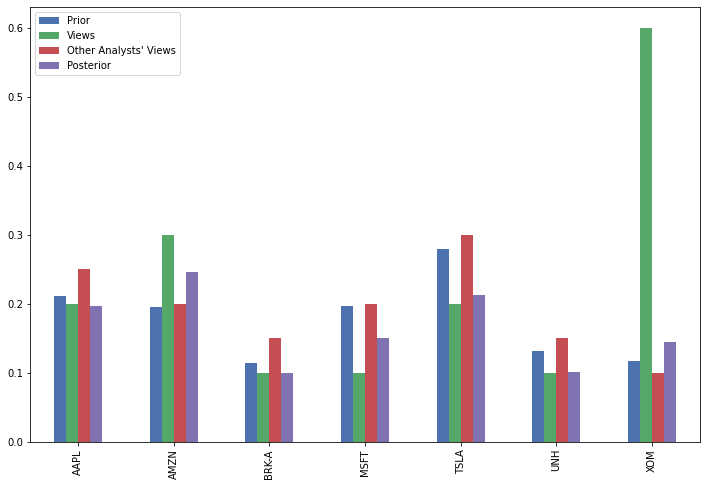

In [28]:
#final expected returns, alongside the market implied returns, our predicted returns, and other analysts' predicted returns

rets_df.plot.bar(figsize=(12,8))

More conservative (and diversified) than my earlier simulation. Previously, views were only punished for disagreeing with market implied returns, but now they are also punished for disagreeing with other analysts' predictions.

In [16]:
#portfolio allocation:

from pypfopt import EfficientFrontier, objective_functions

ef = EfficientFrontier(ret_bl, S)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

C:\Users\samdo\anaconda3\lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:257: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('AAPL', 0.18438),
             ('AMZN', 0.25312),
             ('BRK-A', 0.07857),
             ('MSFT', 0.12061),
             ('TSLA', 0.15239),
             ('UNH', 0.07388),
             ('XOM', 0.13705)])

<AxesSubplot:ylabel='None'>

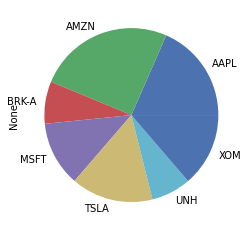

In [17]:
pd.Series(weights).plot.pie()

In [18]:
#hypothetical allocation of $15000

from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=15000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $1319.95


C:\Users\samdo\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


{'AAPL': 18, 'AMZN': 38, 'MSFT': 7, 'TSLA': 12, 'UNH': 2, 'XOM': 18}